In [10]:
import numpy as np
import os
import xarray as xr
import glob
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.colors import BoundaryNorm
import matplotlib.colors as mcolors
import dask.array as da
import pickle
from scipy.stats import t
import matplotlib.ticker as ticker
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.ticker import FuncFormatter

In [11]:
# reading in ERA5 u, v, w and q

base_path = '/data/rong4/Data/ERA5/3hourly/quvw_US'

years = [str(year) for year in range(2001, 2019)]

def get_files(folder, component):

    files = glob.glob(os.path.join(base_path, folder, f"era5.{component}.*.nc"))

    filtered_files = [f for f in files if any(year in f for year in years)]
    
    return filtered_files

# Get the files for each component

u_files = get_files('u_component_of_wind', 'u_component_of_wind')

v_files = get_files('v_component_of_wind', 'v_component_of_wind')

w_files = get_files('vertical_velocity', 'vertical_velocity')

q_files = get_files('specific_humidity', 'specific_humidity')

all_files = u_files + v_files + q_files + w_files

# open all datasets at once

uvq = xr.open_mfdataset(all_files, combine='by_coords', chunks={'time': 24})

uvq['time'] = uvq['time'] - pd.Timedelta(hours=6)

winds = uvq.sel(level=850)

winds = winds.where(
    
    (winds.time.dt.hour.isin([0, 6, 12])) &
    
    (winds.time.dt.month.isin([5, 6, 7, 8, 9])) &
    
    (winds.time.dt.year.isin(range(2001, 2019))),
    
    drop=True
)

winds_avg = winds.resample(time='D').mean().dropna(dim='time', how='all')

In [13]:
times = winds_avg['time'].data

pressure = uvq['level'].data

latitudes = winds_avg['latitude'].data

longitudes = winds_avg['longitude'].data

In [14]:
# reading in ERA5 geopotential height & temperature

tz_path = '/home/annierosen16/data/era5sgp/era5_ml_t_geopotential_full_sgp'

file_pattern = f"{tz_path}/ERA5_*"

file_list = glob.glob(file_pattern)

all_tz = xr.open_mfdataset(file_list, combine='by_coords', chunks={'time': 24})

all_tz = all_tz.assign_coords(valid_time=all_tz.valid_time - pd.Timedelta(hours=6))

tzdf = all_tz.sel(valid_time=all_tz.valid_time[all_tz.valid_time.dt.hour == 12])

tzdf['valid_time'].shape, tzdf['pressure_level'].data.shape

((2754,), (37,))

In [15]:
# removes underground values, contains advections and mean wind profiles

with open('master_clean.pkl', 'rb') as f:
    
    master = pickle.load(f)

In [16]:
master['mean_w_profile'] = master['mean_w_profile'].apply(lambda x: -x)

idx_600 = np.where(pressure == 600)[0][0]

master['w_600'] = master['mean_w_profile'].apply(lambda x: x[idx_600] if len(x) > 20 else None)

In [17]:
wetapes = master[master['wetape']==True].reset_index(drop=True)

wetapes_sorted = wetapes.sort_values(by='w_600', ascending=False).reset_index(drop=True)

dryapes = master[master['dryape']==True].reset_index(drop=True)

dryapes_sorted = dryapes.sort_values(by='w_600', ascending=False).reset_index(drop=True)

In [18]:
wet_apes_dates = np.unique(wetapes['date'])

dry_apes_dates = np.unique(dryapes['date'])

2005-05-07 00:00:00 37.5 -105.0


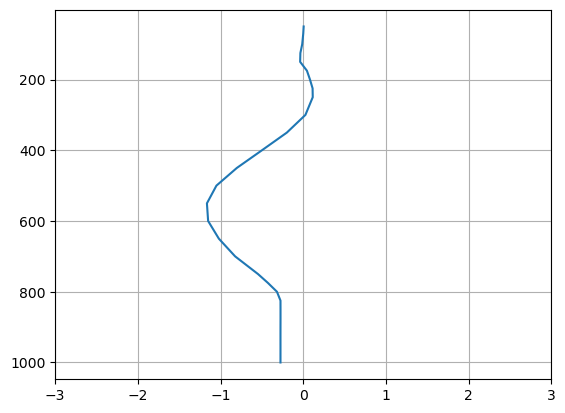

In [23]:
idx = -1

sample_date = wetapes_sorted['date'].iloc[idx]

sample_lon = wetapes_sorted['longitude'].iloc[idx]

sample_lat = wetapes_sorted['latitude'].iloc[idx]

plt.plot(wetapes_sorted['mean_w_profile'].iloc[idx], pressure)

print(sample_date, sample_lat, sample_lon)

plt.xlim(-3, 3)

plt.grid()

plt.gca().invert_yaxis()

/home/annierosen16/anaconda3/envs/annieenv/lib/python3.9/site-packages/dask/array/core.py:1712: FutureWarning: The `numpy.column_stack` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  warnings.warn(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


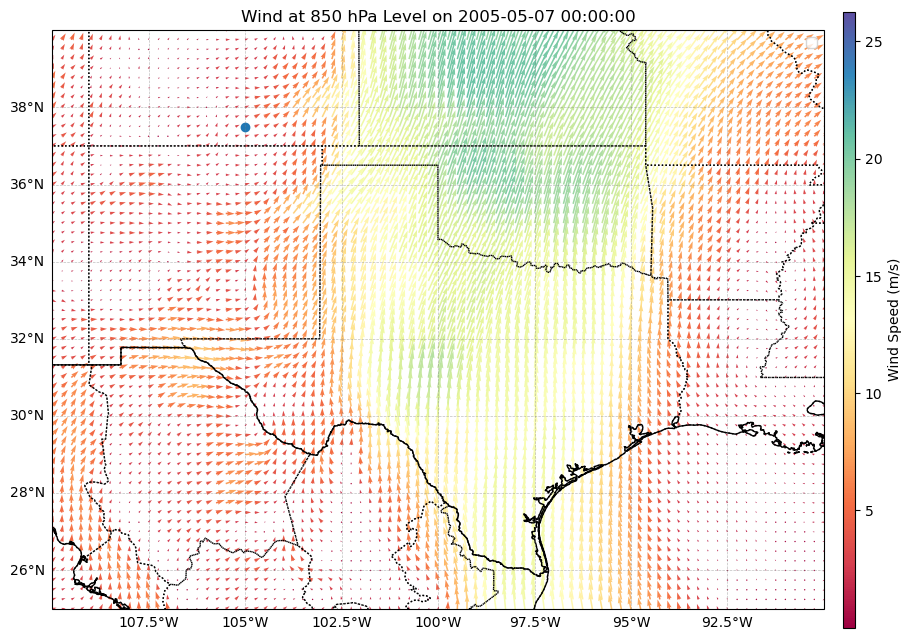

In [26]:
winds_date_idx = np.where(times == sample_date)[0][0]

filtered_wetapes = wetapes[wetapes['date'] == sample_date]

u_sample = winds_avg['u'][winds_date_idx, :, :].data

v_sample = winds_avg['v'][winds_date_idx, :, :].data

# Create a meshgrid for latitudes and longitudes
lon, lat = np.meshgrid(longitudes, latitudes)

# Calculate wind speed magnitude
wind_speed = np.sqrt(u_sample**2 + v_sample**2)

# Create a figure with a Cartopy projection
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})

# Add geographic features
ax.add_feature(cfeature.COASTLINE)

ax.add_feature(cfeature.BORDERS)

ax.add_feature(cfeature.STATES, linestyle=':')

# Plot the wind vectors using quiver
q = ax.quiver(lon, lat, u_sample, v_sample, wind_speed, scale=500, width=0.002, transform=ccrs.PlateCarree(), cmap='Spectral')

# Add a colorbar to indicate wind speed
cbar = plt.colorbar(q, ax=ax, orientation='vertical', pad=0.02, aspect=50)

cbar.set_label('Wind Speed (m/s)')

# Optionally, add a key to the quiver plot
ax.quiverkey(q, 0.9, -0.1, 10, '10 m/s', labelpos='E')

# Set the extent of the map [min_lon, max_lon, min_lat, max_lat]
ax.set_extent([-110, -90, np.min(latitudes), 40])

# Add gridlines
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')

plt.scatter(sample_lon, sample_lat)

gl.top_labels = False

gl.right_labels = False

gl.xformatter = ccrs.cartopy.mpl.gridliner.LONGITUDE_FORMATTER

gl.yformatter = ccrs.cartopy.mpl.gridliner.LATITUDE_FORMATTER

# Add a title
plt.title(f'Wind at 850 hPa Level on {sample_date}')

# Add a legend
plt.legend(loc='upper right')

# Show the plot
plt.show()
